- [ ] You should present a Jupyter notebook portfolio, with Markdown cells inserted at appropriate places to explain your code and describe your analysis.
- [ ] This portfolio should include the **aims, methodology, results and discussion** of your data analysis in a concise and readable fashion.

- Exposition: Your portfolio should b e well organised, and you should aim to write concisely. For each question, you should explain the problem, the data and the aims of the analysis. You should also describe and discuss the machine learning techniques that you have used and the data preparation steps you did (when necessary).
- Data visualisations: Your portfolio should include appropriate and well-presented visualisations that are meaningful to the analysis. For instance, when presenting a plot, you should provide readable labels, axis values, etc.
- Application of techniques: Your portfolio should include the correct use of the machine learning techniques and the interpretation of the results obtained from these techniques.
- Presentation of results: Describe the results of your analysis and their interpretations. Software output is not a valid answer. You must format and present your answer appropriately (tables, graphs, important measures, etc.). You should not add irrelevant information when presenting the results. 
- Discussion: Based on your results, describe the conclusions of your analysis.

# A model for diagnosing cancer

## Exploring Dataset

Determining whether a tumour is malignant or benign is one of the challenging aspects when treating cancer. The growth rate of benign tumors is typically slow, and they don't have the ability to spread. On the other hand, malignant tumors tend to grow quickly, invade and damage surrounding healthy tissues, and can spread to other parts of the body. Therefore, developing an accurate classification model that can differentiate between benign and malignant tumors is crucial in ensuring that patients receive the appropriate treatment and care. Machine learning techniques can help identify cancer types by extracting the differences in cell nucleus features.

In this part of the assignment, we will extend the analysis on the Breast Cancer Wisconsin (diagnostic) dataset and try to build a model that can be used on clinical setting. 

The breast-cancer.csv data set provided contains:

1. Patient ID number
2. Diagnosis (M = malignant, B = benign)
3. Ten cell nucleus features, namely:
   * radius (mean of distances from centre to points on the perimeter)
   * texture (standard deviation of grayscale values)
   * perimeter
   * area
   * smoothness (local variation in radius lengths)
   * compactness (perimeter2 / area - 1.0)
   * concavity (severity of concave portions of the contour)
   * concave points (number of concave portions of the contour)
   * symmetry
   * fractal dimension (‘coastline approximation’ - 1)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('breast-cancer.csv')
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


To facilitate the construction of a machine learning model, the diagnostic labels in the dataset will be encoded appropriately. In the given dataset, the label "malignant" is represented by the letter "M," while the label "benign" is represented by the letter "B." By encoding the labels in this manner, we can prepare the data for training and utilize machine learning algorithms effectively.

> M = malignant

> B = benign




In [2]:
data.isnull().sum()

id                        0
diagnosis                 0
radius_mean               0
texture_mean              0
perimeter_mean            0
area_mean                 0
smoothness_mean           0
compactness_mean          0
concavity_mean            0
concave points_mean       0
symmetry_mean             0
fractal_dimension_mean    0
dtype: int64

The output of the command `data.isnull().sum()` reveals that there are no missing values present in any of the columns within the Breast Cancer Wisconsin dataset. This suggests that the dataset is complete, with no null or missing data points, enabling us to proceed with the analysis without the need for imputation or handling missing values.

In binary classification problems, it is common to designate one class as the positive class and the other as the negative class, based on the specific problem and analysis objectives. Considering the significance of correctly identifying malignant tumors, I will redefine the labels by assigning the value 1 to represent malignant cases and 0 to represent benign cases. This relabeling will help prioritize the accurate identification of malignant tumors within the dataset.

> M = 1

> B = 0


In [3]:
# Encode diagnosis labels into numerical values
data['diagnosis'] = data['diagnosis'].map({'M': 1, 'B': 0})

# Verify the encoding
print(data['diagnosis'].value_counts())

0    357
1    212
Name: diagnosis, dtype: int64


Based on the provided data, there are 357 cases of benign tumors and 212 cases of malignant tumors. 

Considering that the patient ID does not hold any significance in the diagnosis, we will exclude it from the list of features. Consequently, we will separate the features from the target variable, enabling us to train our model effectively.

In [4]:
# Separate features (X) and target variable (y)
X = data.drop(['id', 'diagnosis'], axis=1)  # Drop the 'id' and 'diagnosis' columns to get the features
y = data['diagnosis']  # Select the 'diagnosis' column as the target variable

## Visualization of dataset

### Distribution of data

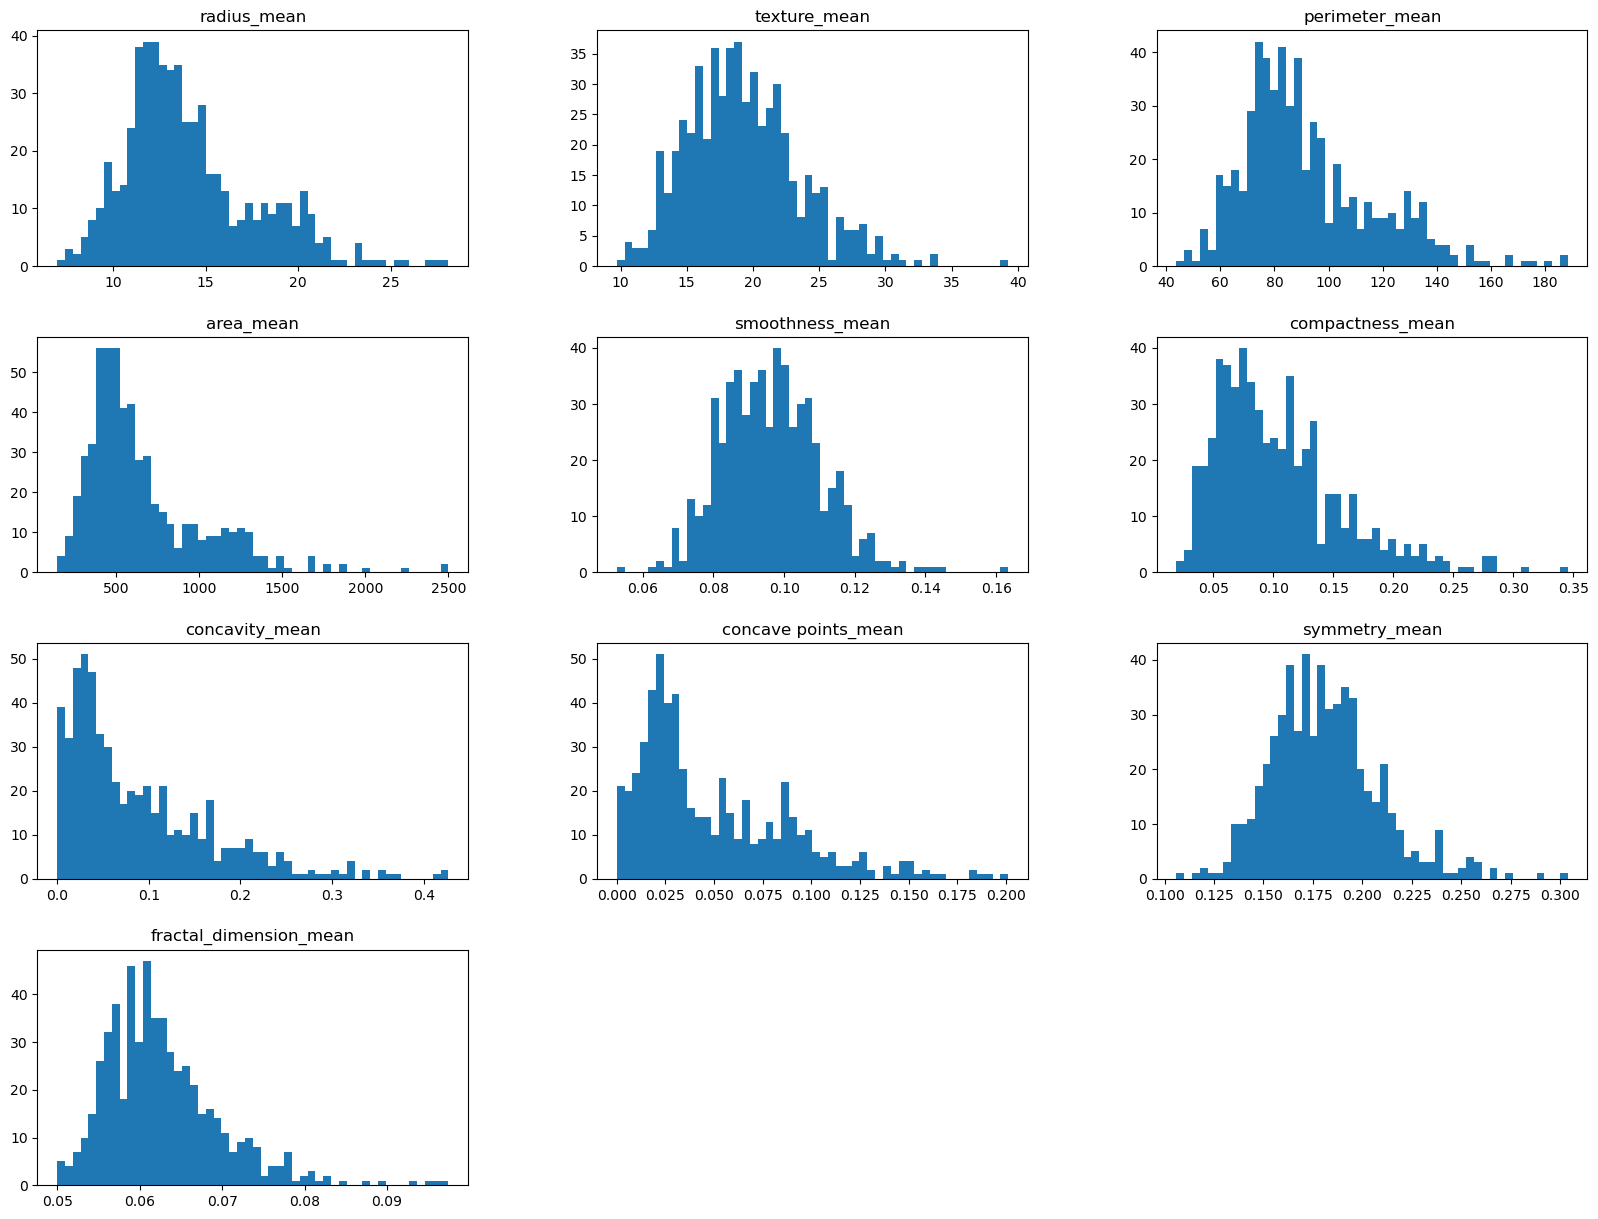

In [5]:
X.hist(bins=50, figsize=(20, 15), grid=False)
plt.show()

The observation that most of the features are right-skewed indicates that they might require certain transformations to achieve a more normal distribution. 

Skewed data can have different impacts on logistic regression and decision tree models:

**1. Logistic Regression:**
   - Skewed data: Logistic regression assumes a linear relationship between predictors and the log-odds of the target variable. If predictors are heavily skewed, this assumption may be violated, potentially leading to biased model estimates.
   - Transformation: Transforming skewed predictors in logistic regression can help achieve a more linear relationship and improve model performance. Common transformations include logarithmic, power, or Box-Cox transformations.

**2. Decision Tree:**
   - Skewed data: Decision trees can handle skewed data without requiring transformation. Skewness does not affect the ability of decision trees to identify informative splits based on the ordering of predictors.
   - Impurity measures: Decision tree algorithms use impurity measures like Gini index or entropy, which are not influenced by data skewness.

In our case, since the predictors are not heavily skewed, we won't perform any data transformation. However, since the predictors have different units of measurement, we might consider scaling the data to ensure all features are on a similar scale for modeling purposes.

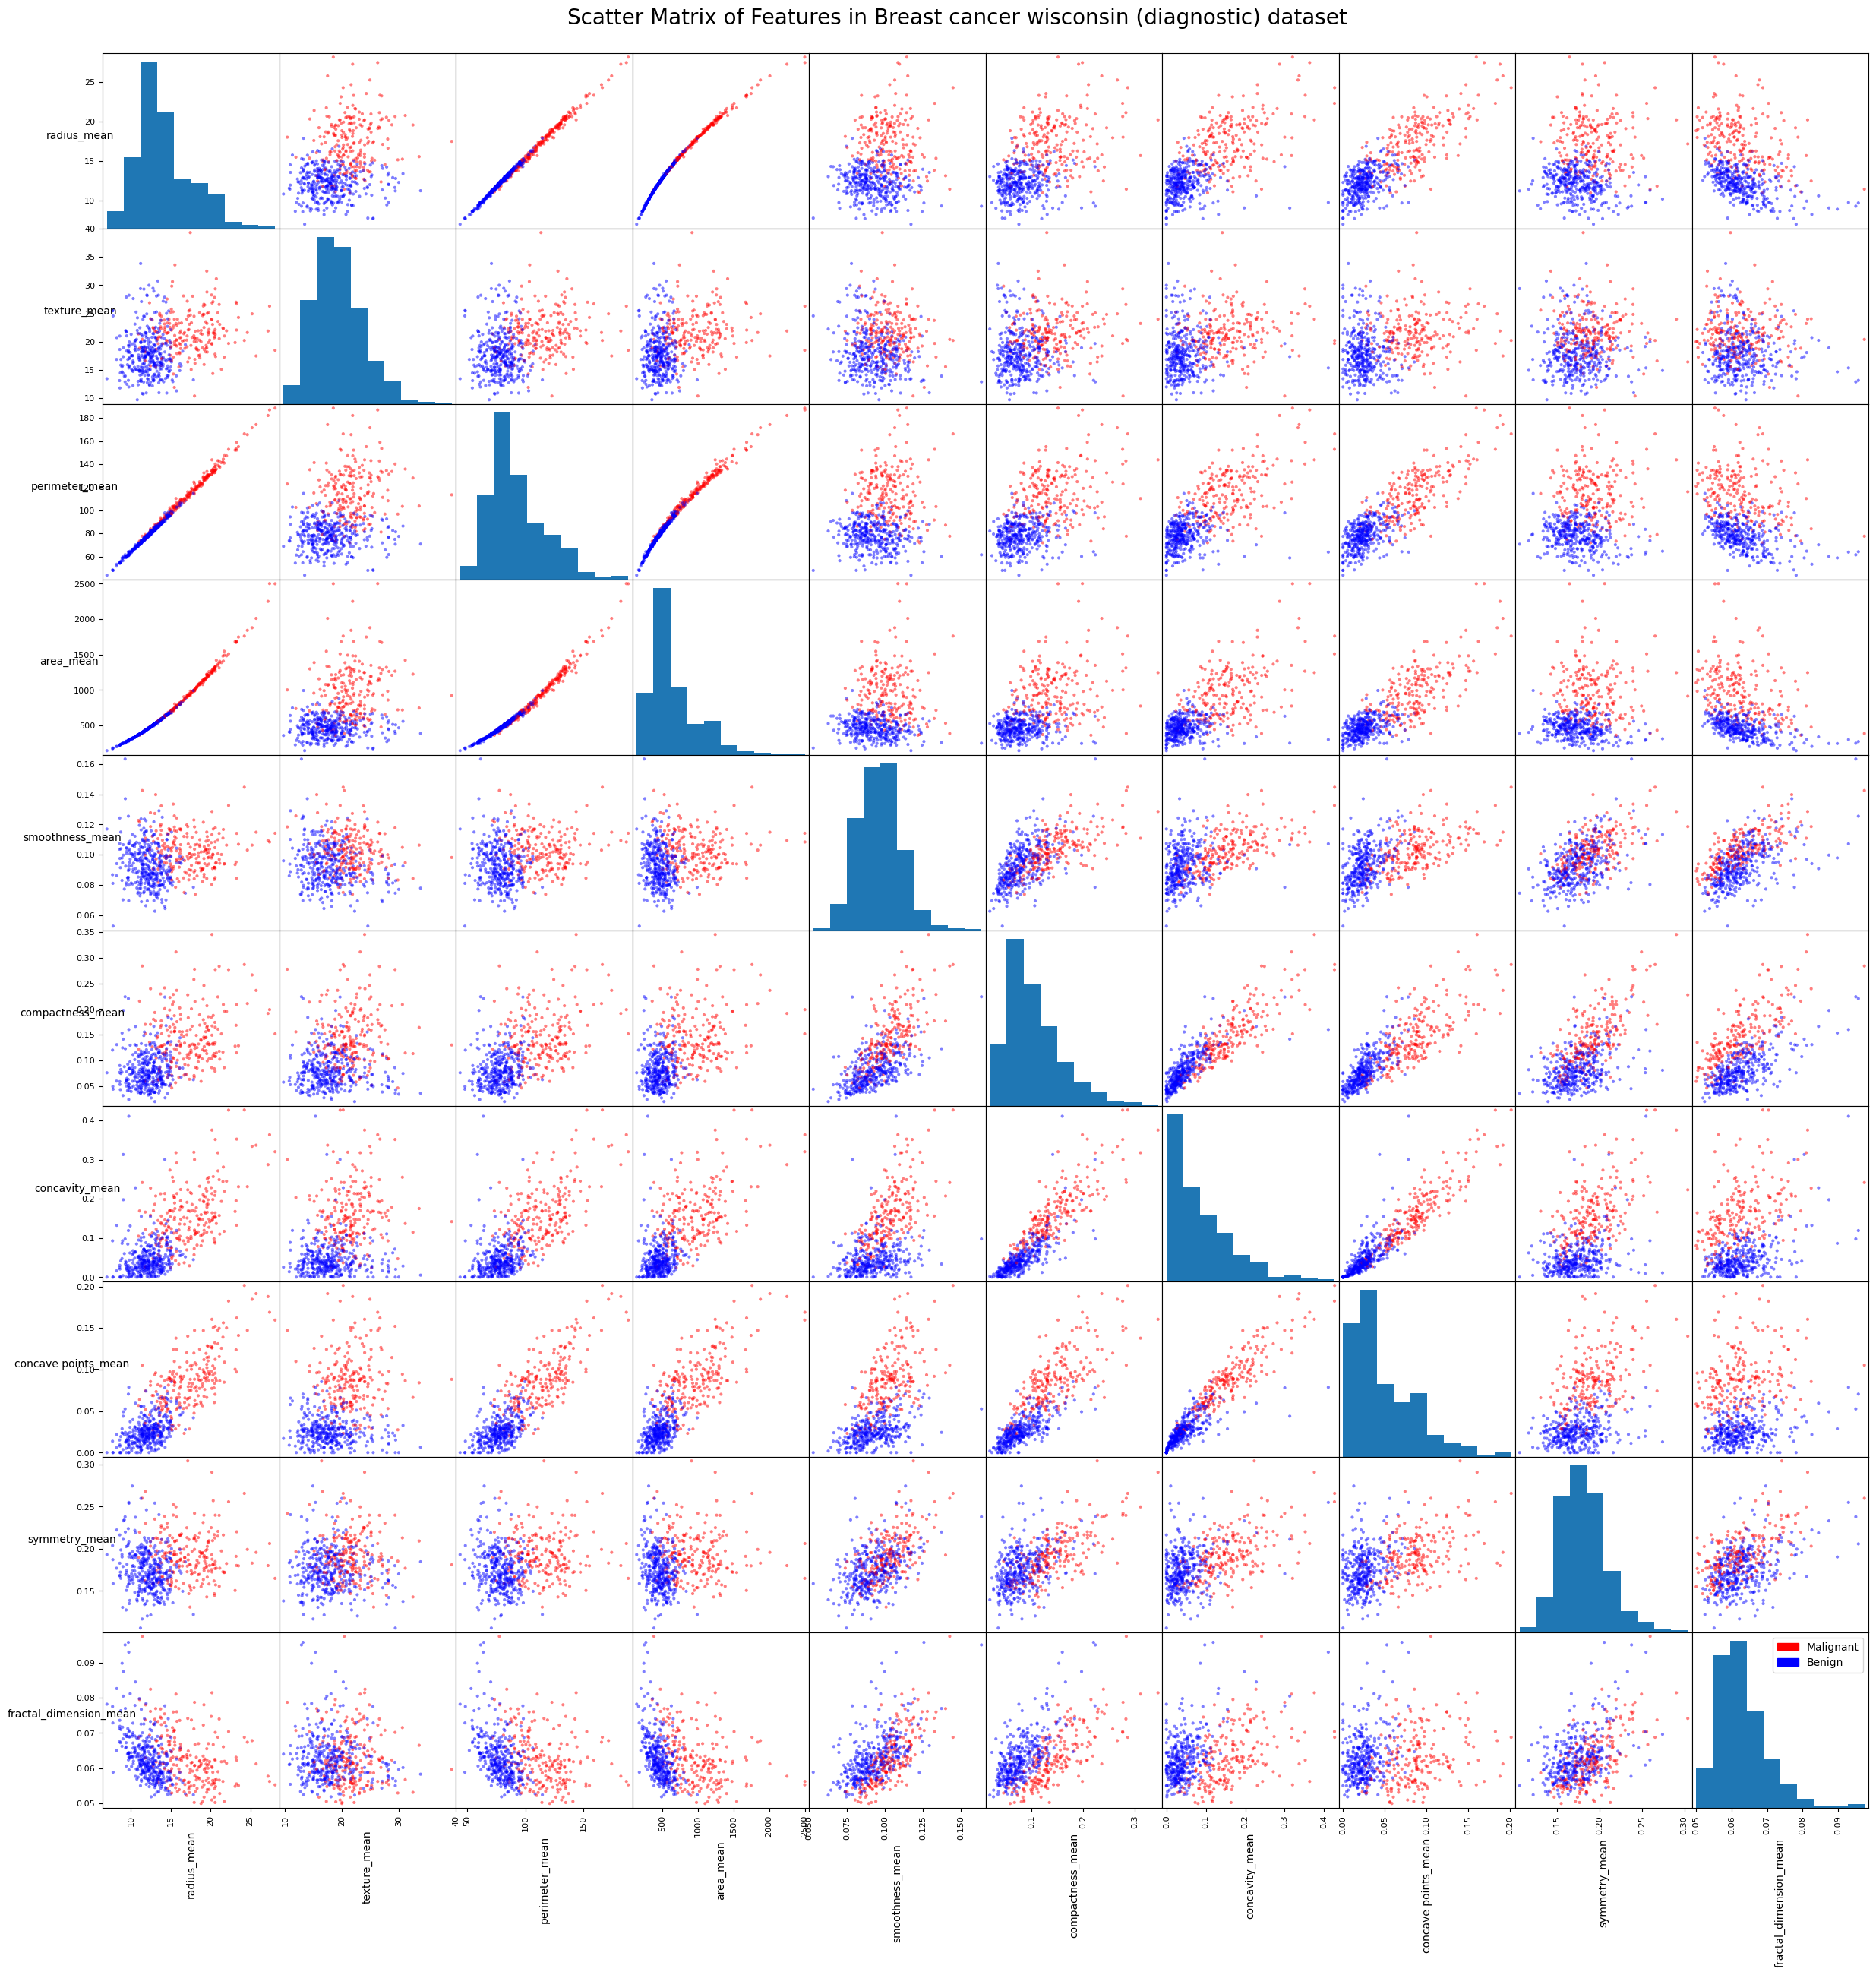

In [6]:
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Define colors for malignant and benign data points
# Red - Malignant
# Blue - Benign
colors = ['red' if label == 1 else 'blue' for label in y]

scatter_matrix_plot = scatter_matrix(X, figsize=(30, 30), diagonal='hist', color=colors)

# Create empty scatter plots with the same colors as our actual data points
red_patch = mpatches.Patch(color='red', label='Malignant')
blue_patch = mpatches.Patch(color='blue', label='Benign')

for i, axs in enumerate(scatter_matrix_plot):
    for j, ax in enumerate(axs):
        if i == len(scatter_matrix_plot) - 1:
            ax.set_xlabel(X.columns[j], rotation=90)
        if j == 0:
            ax.set_ylabel(X.columns[i], rotation=0)          

for ax in scatter_matrix_plot.ravel():
    ax.tick_params(axis='x', labelrotation = 90)
    ax.tick_params(axis='y', labelrotation = 0)
    
# Add legend
plt.legend(handles=[red_patch, blue_patch], loc='best')

plt.suptitle('Scatter Matrix of Features in Breast cancer wisconsin (diagnostic) dataset', fontsize=20, y=0.9)      
plt.show()

The scatterplot above visualizes the relationship between each feature in the dataset. The data instances are color-coded, with `red` representing `malignant` instances and `blue` representing `benign` instances. From the scatterplot, it is apparent that certain features exhibit correlation with one another, either in a linear or non-linear fashion. Some of these correlations can be inferred directly from the feature definitions. For example, the perimeter is linearly correlated with the radius, and the area is polynomially related to the radius.

Formulas for perimeter and area:

- Perimeter: The perimeter is the total length of the boundary of a shape. In the case of a circle, the perimeter is directly related to the radius `r` and can be calculated using the formula:
 
 <center>Perimeter = $2\pi r$</center>

- Area: The area is the measure of the surface enclosed by a shape. For a circle, the area is polynomially related to the radius `r` and can be calculated using the formula:

<center>Area = $\pi r^2$</center>
 
In these formulas, `r` represents the radius of the circle. </center>

## Finding Correlation among features

To investigate collinearity further and identify features that are strongly correlated, we can plot a correlation matrix heatmap. This heatmap provides a visual representation of the pairwise correlations between features. By analyzing the heatmap and scatterplot, we can determine which features exhibit high correlation coefficients and consider removing one of the features from pairs with strong correlation.

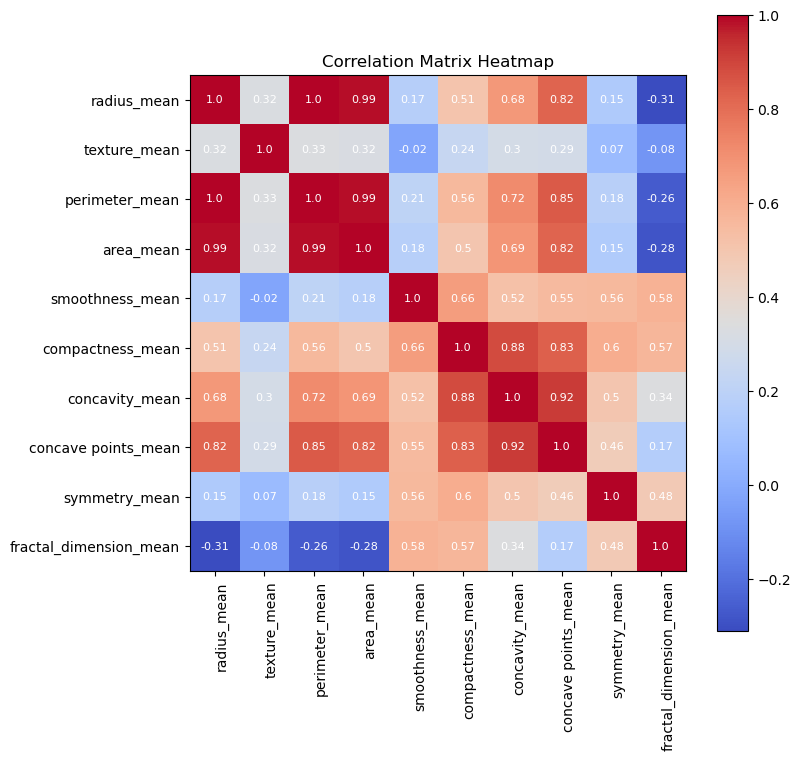

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# calculate the correlation matrix
corr_matrix = X.corr()

# create the heatmap plot
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(corr_matrix, cmap='coolwarm')

# add a colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# set the axis labels
ax.set_xticks(np.arange(len(corr_matrix.columns)))
ax.set_yticks(np.arange(len(corr_matrix.columns)))
ax.set_xticklabels(corr_matrix.columns, fontsize=10)
ax.set_yticklabels(corr_matrix.columns, fontsize=10)

# rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

# add the correlation coefficients in each cell of the heatmap
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        text = ax.text(j, i, round(corr_matrix.iloc[i, j], 2), ha="center", va="center", color="w", fontsize=8)

# set the title
ax.set_title("Correlation Matrix Heatmap")

# show the plot
plt.show()

Based on the provided heatmap, it is evident that certain features exhibit strong correlations. For instance, the feature "perimeter mean" and "area mean" are directly correlated with the "radius mean," as observed in the scatter plot. Additionally, the features "compactness mean," "concave points mean," and "concavity mean" show high correlation among themselves. 

Considering these correlations, we can drop the features that are highly correlated and retain only one representative feature from each group for our model. The correlated features and their corresponding groups are as follows:

1. Correlated features with "radius mean":
   - "perimeter mean"
   - "area mean"

2. Correlated features with "compactness mean":
   - "concave points mean"
   - "concavity mean"

3. Other features:
   - "texture mean"
   - "smoothness mean"
   - "symmetry mean"
   - "fractal dimension mean"

Therefore, to avoid multicollinearity and maintain independence among the features, we will remove the correlated columns and retain only the independent features for our model.

In [8]:
X = X[['radius_mean', 'texture_mean', 'smoothness_mean', 'compactness_mean', 'symmetry_mean', 'fractal_dimension_mean']]

Nex, we will perform stratified sampling to split the data into training and test sets in 85/25 ration, to ensure that the proportion of target labels is maintained in both sets. This will ensure that our training and test sets are representative of the entire dataset.

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=123, stratify=y)

Scaling data is a separate consideration from handling data skewness. Scaling refers to the process of transforming the values of the predictors to a consistent scale, typically between a specific range or with a mean of 0 and a standard deviation of 1. The purpose of scaling is to ensure that all predictors contribute equally to the model and to prevent variables with larger scales from dominating the modeling process.

Here's how scaling relates to logistic regression and decision trees:

1. Logistic Regression:
   - Scaling: Logistic regression models can benefit from scaling the predictors, especially when the predictors have different scales. Scaling the predictors helps in cases where the optimization algorithm used to fit the logistic regression model (e.g., gradient descent) converges faster or performs better with scaled data.
   - Standardization: Common scaling techniques in logistic regression include standardization (subtracting the mean and dividing by the standard deviation) or normalization (scaling values between a specified range, e.g., 0-1).

2. Decision Tree:
   - Scaling: Decision trees, in general, are not affected by scaling since the algorithm makes decisions based on relative ordering rather than absolute values. Therefore, scaling is not necessary for decision trees.
   - Interpretability: Scaling does not impact the interpretability of decision trees since the splits are determined by the relative ordering of predictors.

In summary, while scaling can be beneficial for logistic regression models to ensure fair contribution of predictors, it is generally not necessary for decision trees. However, scaling can still be applied to decision tree models if desired, without affecting their interpretability.

For our dataset, we will scale the data when training our logistic regression model, while leaving the data unscaled for decision trees.

In [10]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = std_scaler.fit_transform(X_train)

# Use the fitted scaler to transform the test data
X_test_scaled = std_scaler.transform(X_test)

To facilitate further analysis and visualization, we can associate the feature names with the scaled data obtained from the scaling process. By attaching the feature names, we can plot and examine the scaled features, allowing for better insights and interpretation.

In [11]:
# Create new DataFrames with the scaled data and feature names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_train.columns)

### Tuning hyperparameter for Logistic Regression

To optimize the hyperparameters for logistic regression, we can employ techniques such as grid search or random search in conjunction with cross-validation.

1. Define the search space for hyperparameters: Specify the range or a list of values for each hyperparameter that you wish to explore. Let's review the explanation of the hyperparameters and their corresponding values:

   - 'C': The 'C' parameter regulates the inverse of the regularization strength. Smaller 'C' values lead to stronger regularization, which can prevent overfitting by penalizing large coefficient values. The provided values in the search space, such as [0.01, 0.1, 1, 10, 100], represent different levels of regularization strength to be tested.

   - 'penalty': The 'penalty' parameter determines the type of regularization to be applied. In this case, 'l2' is employed, representing L2 regularization (Ridge regression). L2 regularization adds the squared magnitudes of the coefficients to the loss function, encouraging smaller coefficient values. Only 'l2' is included in the search space in this example.

   - 'class_weight': The 'class_weight' parameter addresses class imbalance by assigning different weights to various classes. The value 'None' represents the default setting, where all classes are treated equally. Conversely, 'balanced' automatically adjusts the weights based on the class frequencies in the input data.

   - 'fit_intercept': The 'fit_intercept' parameter determines whether an intercept term should be included in the logistic regression model. When set to 'True', an intercept is included, while 'False' excludes it.

2. Select a scoring metric: Choose an appropriate metric for evaluating the performance of different hyperparameter combinations. Options include accuracy, precision, recall, F1-score, or any other metric that suits your specific problem. **In our case, since we require both high precision and high recall, we will use the F1-score as the scoring metric.**

3. Set up the cross-validation strategy: Decide on the number of folds or the cross-validation strategy to use. Common choices include k-fold cross-validation or stratified k-fold cross-validation.

4. Conduct the hyperparameter search:
   - Grid Search: Conduct an exhaustive search over all possible combinations of hyperparameters using GridSearchCV from scikit-learn. It evaluates the model performance for each combination through cross-validation and selects the best combination.




In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'class_weight': [None, 'balanced'],
    'fit_intercept': [True, False],
   }

grid_search = GridSearchCV(LogisticRegression(), param_grid, scoring='f1', cv=5)
grid_search.fit(X_train_scaled, y_train)

grid_search.best_params_

{'C': 10, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l2'}

The `param_grid` dictionary in the code snippet defines the grid of hyperparameters to be explored during the grid search process for the logistic regression model. It specifies different values to be tested for each hyperparameter.

The grid search algorithm will systematically evaluate multiple combinations of these hyperparameters and select the best combination based on the specified scoring metric.

In the given example, the combination `'{'C': 10, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l2'}` represents a specific set of hyperparameters that have been identified as the best choice according to the results of the grid search. It suggests using a regularization strength (`C`) of 10, employing balanced class weights, including an intercept term (`fit_intercept` set to True), and applying L2 regularization (`penalty` set to 'l2').

#### Training Logistic Regression Model with optimal hyperparameters

In [14]:
log_reg = LogisticRegression(C=10, class_weight='balanced', fit_intercept=True, penalty='l2')
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(C=10, class_weight='balanced')

(303, 6)
(180, 6)


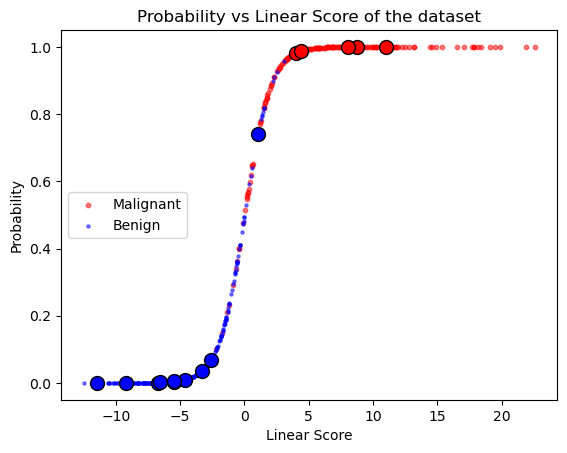

In [44]:
import math
import numpy as np
import matplotlib.pyplot as plt

# Filter X_train_scaled based on Y_train_s values equal to 1
X_subset_malignant = X_train_scaled[y_train == 1]
X_subset_benign = X_train_scaled[y_train == 0]

# Calculate the scores for the subset using the logistic regression coefficients and intercept
X_scores_malignant = np.dot(X_subset_malignant, log_reg.coef_.reshape(-1, 1)) + log_reg.intercept_
X_scores_benign = np.dot(X_subset_benign, log_reg.coef_.reshape(-1, 1)) + log_reg.intercept_

# Print the scores for the subset
print(X_subset_benign.shape)
print(X_subset_malignant.shape)

sigmoid_prob_mal = 1/(1 + np.exp(-X_scores_malignant))
sigmoid_prob_ben = 1/(1 + np.exp(-X_scores_benign))

np.random.seed(4)  # Set the seed
random_indices = np.random.choice(X_test_scaled.shape[0], 15, replace=False)

for i in random_indices:
    X_test_0 = X_test_scaled[i]     
    
    X_score_0 = np.dot(X_test_0, log_reg.coef_.reshape(6,1)) + log_reg.intercept_
    sigmoid_prob_0 = 1/(1 + math.exp(-X_score_0))
    
    if y_test.iloc[i] == 0:
        color = 'blue'
        label = 'Real Benign'
    else:
        color = 'red'
        label = 'Real Malignant'
    
    plt.plot(X_score_0, sigmoid_prob_0, marker="o", markersize=10, markeredgecolor='black', markerfacecolor=color)

plt.scatter(X_scores_malignant, sigmoid_prob_mal, s=10, alpha=0.5, c='red', label="Malignant")
plt.scatter(X_scores_benign, sigmoid_prob_ben, s=5, c='blue', alpha=0.5, label="Benign")
plt.title("Probability vs Linear Score of the dataset")
plt.xlabel("Linear Score")
plt.ylabel("Probability")
plt.legend(loc="center left")
plt.show()

In [17]:
# X_scores = np.dot(X_train_scaled, log_reg.coef_.reshape(6,1)) + log_reg.intercept_
# sigmoid_prob = 1/(1 + np.exp(-X_scores))

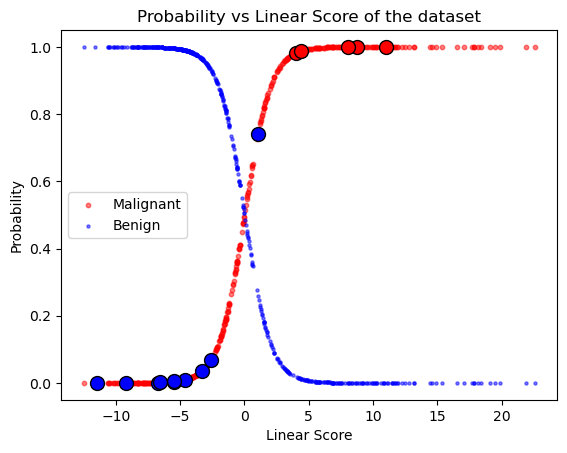

In [18]:
# import math
# import numpy as np
# import matplotlib.pyplot as plt

# np.random.seed(4)  # Set the seed
# random_indices = np.random.choice(X_test_scaled.shape[0], 15, replace=False)

# for i in random_indices:
#     X_test_0 = X_test_scaled[i]     
    
#     X_score_0 = np.dot(X_test_0, log_reg.coef_.reshape(6,1)) + log_reg.intercept_
#     sigmoid_prob_0 = 1/(1 + math.exp(-X_score_0))
    
#     if y_test.iloc[i] == 0:
#         color = 'blue'
#         label = 'Real Benign'
#     else:
#         color = 'red'
#         label = 'Real Malignant'
    
#     plt.plot(X_score_0, sigmoid_prob_0, marker="o", markersize=10, markeredgecolor='black', markerfacecolor=color)

# plt.scatter(X_scores, sigmoid_prob, s=10, alpha=0.5, c='red', label="Malignant")
# plt.scatter(X_scores, 1-sigmoid_prob, s=5, c='blue', alpha=0.5, label="Benign")
# plt.title("Probability vs Linear Score of the dataset")
# plt.xlabel("Linear Score")
# plt.ylabel("Probability")
# plt.legend(loc="center left")
# plt.show()

The smaller circles are the probability for training dataset. The bigger circle are for 10 random test set. 

The usual threshold for the logisitic regression is 0.5. In the above diagram, we can see that there are some false positive and false negatives. So, we might need threshold other than 0.5 for high precision and high recall. 

Predictions and Accuracy of Logisitic Regression with default hyperparameters

In [19]:
y_train_pred = log_reg.predict(X_train_scaled)
y_test_pred = log_reg.predict(X_test_scaled)

In [20]:

def plotMisclassifiedPoints(X_train_scaled_df, y_train, X_test_scaled_df, y_test, title):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    fig.suptitle(title)

    # Plot for predicted target values - Training Data
    predicted_plot = axes[0].scatter(X_train_scaled_df['radius_mean'], X_train_scaled_df['texture_mean'], c=y_train_pred, cmap='coolwarm')
    axes[0].set_xlabel('mean radius')
    axes[0].set_ylabel('mean texture')
    axes[0].set_title('Predicted Target Values - Training Data')

    misclassified = np.where(y_train != y_train_pred)[0]
    axes[0].scatter(X_train_scaled_df.iloc[misclassified]['radius_mean'], X_train_scaled_df.iloc[misclassified]['texture_mean'], 
                    marker='x', s=100, linewidth=2, c='black', label='Misclassified')

    # Plot for predicted target values - Test Data
    scatter = axes[1].scatter(X_test_scaled_df['radius_mean'], X_test_scaled_df['texture_mean'], c=y_test_pred, cmap='coolwarm')
    axes[1].set_xlabel('mean radius')
    axes[1].set_ylabel('mean texture')
    axes[1].set_title('Predicted Target Values - Test Data')

    # Highlight mispredicted data points with a different color
    misclassified = np.where(y_test != y_test_pred)[0]
    axes[1].scatter(X_test_scaled_df.iloc[misclassified]['radius_mean'], X_test_scaled_df.iloc[misclassified]['texture_mean'], 
                    marker='x', s=100, linewidth=2, c='black', label='Misclassified')

    # Add color bar
    fig.colorbar(scatter, ax=axes)

    plt.legend()
    plt.show()


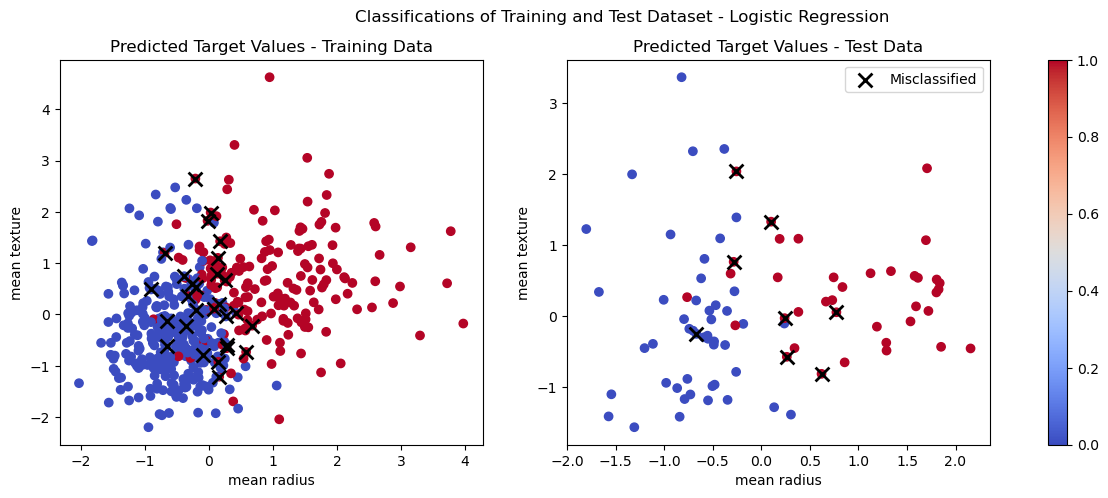

In [21]:
plotMisclassifiedPoints(X_train_scaled_df, y_train, X_test_scaled_df, y_test, "Classifications of Training and Test Dataset - Logistic Regression")

### Precision and Recall for Decison Tree with Default Hyperparameters

In [22]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def drawConfusionMatrix(y_train, y_train_pred, y_test, y_test_pred, title):
# Define the class labels
    classes = ['benign', 'malignant']

    conf_matrix_train = confusion_matrix(y_train, y_train_pred)
    conf_matrix_test = confusion_matrix(y_test, y_test_pred)

    # Create the figure and axes objects
    fig, axs = plt.subplots(ncols=2, figsize=(15, 3))

    # Create the heatmap using matshow
    axs[0].matshow(conf_matrix_train, cmap=plt.cm.Blues)

    # Add colorbar to the heatmap
    # cbar = plt.colorbar(heatmap)

    # Set the ticks and labels for x and y axes
    axs[0].set_xticks(np.arange(len(classes)))
    axs[0].set_xticklabels(classes)
    axs[0].set_yticks(np.arange(len(classes)))
    axs[0].set_yticklabels(classes)

    # Add the count values to each cell
    for i in range(len(classes)):
        for j in range(len(classes)):
            text = axs[0].text(j, i, conf_matrix_train[i, j],
                           ha="center", va="center", color="orange")

    # Set the title and axis labels
    axs[0].set_title(f'{title} - Training Data')
    axs[0].set_xlabel('Predicted Class')
    axs[0].set_ylabel('True Class')
    
    axs[1].matshow(conf_matrix_test, cmap=plt.cm.Blues)

    # Add colorbar to the heatmap
    # cbar = plt.colorbar(heatmap)

    # Set the ticks and labels for x and y axes
    axs[1].set_xticks(np.arange(len(classes)))
    axs[1].set_xticklabels(classes)
    axs[1].set_yticks(np.arange(len(classes)))
    axs[1].set_yticklabels(classes)

    # Add the count values to each cell
    for i in range(len(classes)):
        for j in range(len(classes)):
            text = axs[1].text(j, i, conf_matrix_test[i, j],
                           ha="center", va="center", color="orange")

    # Set the title and axis labels
    axs[1].set_title(f'{title} - Testing Data')
    axs[1].set_xlabel('Predicted Class')
    axs[1].set_ylabel('True Class')

    # Show the plot
    plt.show()

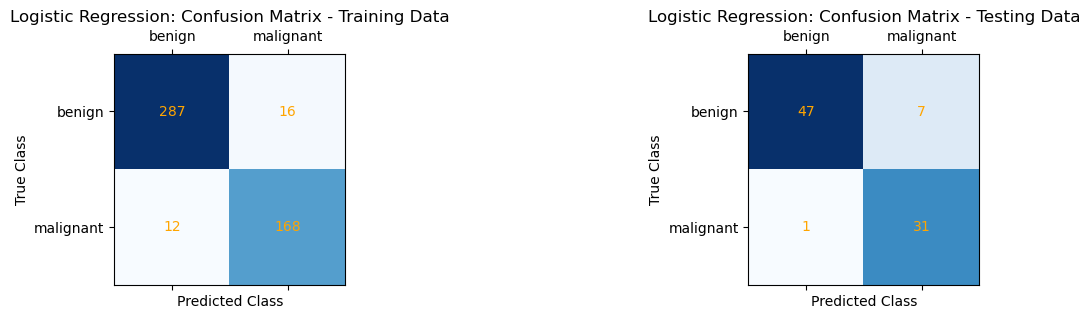

In [23]:
drawConfusionMatrix(y_train, y_train_pred, y_test, y_test_pred, 'Logistic Regression: Confusion Matrix')

In [24]:
from sklearn.metrics import precision_score, recall_score

def printPerformanceMetrics(y_train, y_train_pred, y_test, y_test_pred, tree_type):
    precision_test = precision_score(y_test, y_test_pred)
    recall_test = recall_score(y_test, y_test_pred)
    
    precision_train = precision_score(y_train, y_train_pred)
    recall_train = recall_score(y_train, y_train_pred)    

    print(f"Precision - {tree_type} (Training Dataset): {round( precision_train, 3)}")
    print(f"Recall - {tree_type} (Training Dataset): { round( recall_train, 3) }")    
    print('\n')    
    print(f"Precision - {tree_type} (Test Dataset): {round( precision_test, 3)}")
    print(f"Recall - {tree_type} (Test Dataset): { round( recall_test, 3)}")

In [25]:
printPerformanceMetrics(y_train, y_train_pred, y_test, y_test_pred, "Logistic Regression")

Precision - Logistic Regression (Training Dataset): 0.913
Recall - Logistic Regression (Training Dataset): 0.933


Precision - Logistic Regression (Test Dataset): 0.816
Recall - Logistic Regression (Test Dataset): 0.969


Recall, also known as sensitivity or true positive rate, measures the ability of the model to correctly identify positive instances (e.g., correctly identifying malignant cases in a medical diagnosis). It is calculated as the ratio of true positives to the sum of true positives and false negatives:

Recall = True Positives / (True Positives + False Negatives)

Precision, also known as positive predictive value, measures the accuracy of the model in predicting positive instances. It is calculated as the ratio of true positives to the sum of true positives and false positives:

Precision = True Positives / (True Positives + False Positives)

Here are some key points about recall and precision:

Recall focuses on the ability of the model to avoid false negatives, which means minimizing the instances where positive cases are mistakenly classified as negative. It provides insights into the model's ability to capture all relevant positive instances.
Precision focuses on the ability of the model to avoid false positives, which means minimizing the instances where negative cases are mistakenly classified as positive. It provides insights into the model's accuracy in predicting positive instances.
Recall and precision are inversely related. Increasing the threshold for classifying instances as positive typically increases precision but decreases recall, and vice versa.
Depending on the specific problem and its requirements, you may prioritize either recall or precision. For example, in medical diagnoses, you may prioritize recall to ensure that fewer cases of the disease are missed, even if it means a higher number of false positives. In fraud detection, you may prioritize precision to minimize false alarms, even if it means potentially missing some fraudulent transactions.
The trade-off between recall and precision can be visualized using a precision-recall curve, which shows the relationship between the two metrics for different classification thresholds.

### Decision Tree

In [26]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.tree import DecisionTreeClassifier

# # Create a decision tree classifier
# tree_clf = DecisionTreeClassifier(random_state=123)

# # Define the hyperparameters to be tuned and their possible values
# parameters = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
#               'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
#               'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}

# # Create a GridSearchCV object with 3-fold cross-validation
# clf = GridSearchCV(tree_clf, parameters, cv=3)

# # Fit the GridSearchCV object to the training data
# clf.fit(X_train, y_train)

# # Print the best hyperparameters and their corresponding score
# print('Best hyperparameters:', clf.best_params_)
# print('Best score:', round(clf.best_score_,2))

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Create a decision tree classifier
tree_clf = DecisionTreeClassifier(random_state=123)

# Define the hyperparameters to be tuned and their possible values
parameters = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
}

# Create a GridSearchCV object with 3-fold cross-validation
clf = GridSearchCV(tree_clf, parameters, cv=5, scoring='f1')

# Fit the GridSearchCV object to the training data
clf.fit(X_train, y_train)

# Print the best hyperparameters and their corresponding score
print('Best hyperparameters:', clf.best_params_)
print('Best F1 score:', round(clf.best_score_, 2))


Best hyperparameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 4}
Best F1 score: 0.87


*REWRITE THIS*

Cross-validation and Grid Search were used to determine the optimal hyperparameters for the Decision Tree Classifier. The best combination of hyperparameters found were max_depth of 6, min_samples_leaf of 6, and min_samples_split of 2. This means that the decision tree should not split a node further when the number of samples in the node is less than 2 and each leaf node should have at least 6 samples. The min_samples_split value of 2 is still reasonable as we need high precision and do not want a single malignant sample to be classified as negative. These hyperparameters were chosen after evaluating multiple combinations of hyperparameters to identify the best possible values for our model.

In [27]:
tree_clf_opt = DecisionTreeClassifier(random_state=5, max_depth=5, min_samples_leaf=1, min_samples_split=4)
tree_clf_opt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_split=4, random_state=5)

In [28]:
from sklearn.tree import export_graphviz
from graphviz import Source

export_graphviz(
    tree_clf_opt,
    out_file='tree_clf_opt.dot',
    feature_names=X.columns,
    class_names=['Benign', 'Malignant'],
    filled=True,
    rounded=True,
 
)
src = Source.from_file('tree_clf_opt.dot')
src.render('tree_clf_opt', format='png', cleanup=True, view=True) 

'tree_clf_opt.png'

In [29]:
y_train_pred = tree_clf_opt.predict(X_train)
y_test_pred = tree_clf_opt.predict(X_test)

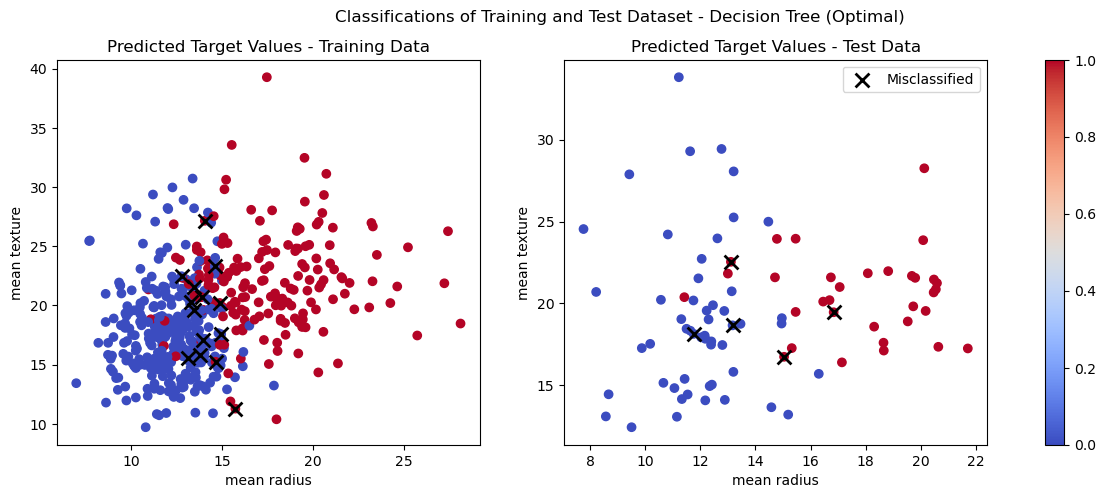

In [30]:
plotMisclassifiedPoints(X_train, y_train, X_test, y_test, "Classifications of Training and Test Dataset - Decision Tree (Optimal)")

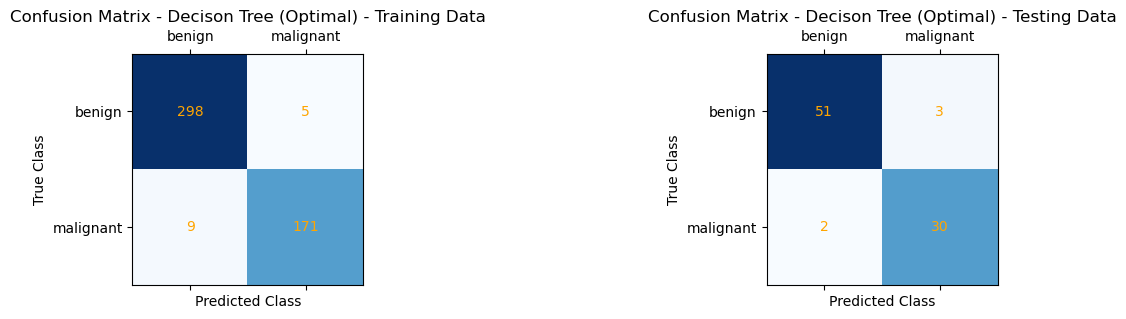

In [31]:
drawConfusionMatrix(y_train, y_train_pred, y_test, y_test_pred, "Confusion Matrix - Decison Tree (Optimal)")


In [32]:
printPerformanceMetrics(y_train, y_train_pred, y_test, y_test_pred, "Decision Tree (Optimal)")

Precision - Decision Tree (Optimal) (Training Dataset): 0.972
Recall - Decision Tree (Optimal) (Training Dataset): 0.95


Precision - Decision Tree (Optimal) (Test Dataset): 0.909
Recall - Decision Tree (Optimal) (Test Dataset): 0.938


Compare the two graphs. We need high recall. So, we will choose logistic regression. The complexity of the decision tree is also high and does not have seemed to generalize properly. So, we will choose logisitc regression. LIST SCORES, AND NUBMERS AND GIVE GOOD DESCRIPTION AND HEADING

TASK 2

To identify the features that have a higher chance of impacting the prediction of the tumor status according to each of the two models, you can analyze the feature importances provided by the models. 

For the logistic regression model, you can access the coefficients of the trained model to understand the impact of each feature. The magnitude of the coefficients indicates the strength of the relationship between each feature and the predicted outcome. Larger coefficients indicate a stronger impact on the prediction. Positive coefficients indicate a positive relationship with the target variable (malignant tumor), while negative coefficients indicate a negative relationship (benign tumor).

For the decision tree model, you can analyze the feature importances derived from the tree structure. The feature importances represent the relative importance of each feature in the decision-making process of the tree. Higher importances indicate a stronger impact on the prediction. The feature importances are calculated based on how much each feature reduces the impurity in the dataset when making decisions at each node of the tree.

Similarities and differences between the two models regarding the impact of features can be observed by comparing their feature importances. Here are some key points to consider:

Similarities:
- Both models can identify important features that contribute to the prediction of tumor status.
- They consider the relationship between the features and the target variable, albeit in different ways.

Differences:
- Logistic regression provides coefficients that indicate the direction and magnitude of the impact, while decision trees provide relative importances.
- Logistic regression assumes a linear relationship between the features and the target variable, whereas decision trees can capture non-linear relationships.
- Logistic regression considers all features simultaneously, whereas decision trees make decisions based on individual features at each split.

In summary, by analyzing the coefficients or feature importances of the logistic regression and decision tree models, you can identify the features that have a higher chance of impacting the prediction of tumor status. The magnitude and direction of the coefficients or the importances of the features can provide insights into their relative importance and relationships with the predicted outcome.

In [33]:
log_reg.coef_[0]

array([ 4.40467365,  1.72178735,  1.18985231,  0.9713134 ,  0.6199688 ,
       -0.20848837])

In [34]:


# Get the feature coefficients
feature_coefficients = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': log_reg.coef_[0]})

# Sort the coefficients by magnitude
sorted_coefficients = feature_coefficients.sort_values(by='Coefficient', ascending=False)

# Print the top features with higher impact
print("Top features impacting prediction according to Logistic Regression:")
print(sorted_coefficients)


Top features impacting prediction according to Logistic Regression:
                  Feature  Coefficient
0             radius_mean     4.404674
1            texture_mean     1.721787
2         smoothness_mean     1.189852
3        compactness_mean     0.971313
4           symmetry_mean     0.619969
5  fractal_dimension_mean    -0.208488


In [35]:


# Get the feature importances
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': tree_clf_opt.feature_importances_})

# Sort the importances in descending order
sorted_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Print the top features with higher impact
print("Top features impacting prediction according to Decision Tree:")
print(sorted_importances)


Top features impacting prediction according to Decision Tree:
                  Feature  Importance
0             radius_mean    0.717875
3        compactness_mean    0.131801
1            texture_mean    0.093478
2         smoothness_mean    0.031173
4           symmetry_mean    0.025673
5  fractal_dimension_mean    0.000000


In [36]:
tree_clf_opt.feature_importances_



array([0.71787489, 0.0934779 , 0.03117319, 0.13180138, 0.02567264,
       0.        ])

When dealing with high cardinality features, impurity-based feature importances can be misleading. In such cases, it's recommended to use permutation importance as an alternative method. Here's an updated code snippet for the decision tree model using permutation importance:

In [37]:
from sklearn.inspection import permutation_importance

# Fit the decision tree model


# Calculate permutation importances
result = permutation_importance(tree_clf_opt, X_test, y_test, n_repeats=10, random_state=123)

# Get the feature importances and their standard deviations
feature_importances = pd.DataFrame({'Feature': X_test.columns, 'Importance': result.importances_mean, 'Std Dev': result.importances_std})

# Sort the importances in descending order
sorted_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Print the top features with higher impact
print("Top features impacting prediction according to Decision Tree (Permutation Importance):")
print(sorted_importances.head(10))


Top features impacting prediction according to Decision Tree (Permutation Importance):
                  Feature  Importance   Std Dev
0             radius_mean    0.287209  0.045349
1            texture_mean    0.059302  0.019767
3        compactness_mean    0.031395  0.017286
2         smoothness_mean    0.020930  0.010137
4           symmetry_mean    0.019767  0.012791
5  fractal_dimension_mean    0.000000  0.000000


TAsk 3

In [38]:
### we might need scaled data for PCA. 

X_train_scaled.shape

(483, 6)

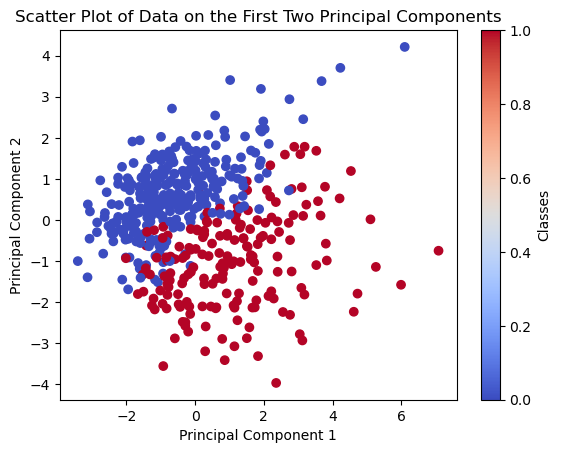

Proportion of Data Variance Explained by the First Two Principal Components: 0.7270239200015349


In [39]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA with two components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

# Scatter plot of the data on the first two principal components
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='coolwarm')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatter Plot of Data on the First Two Principal Components')
plt.colorbar(label='Classes')
plt.show()

# Proportion of data variance explained by the first two principal components
explained_variance_ratio = pca.explained_variance_ratio_
variance_explained = sum(explained_variance_ratio[:2])
print("Proportion of Data Variance Explained by the First Two Principal Components:", variance_explained)


In [40]:
explained_variance_ratio

array([0.46230769, 0.26471623])

explain this variance. it's in the book if you are not sreu. 

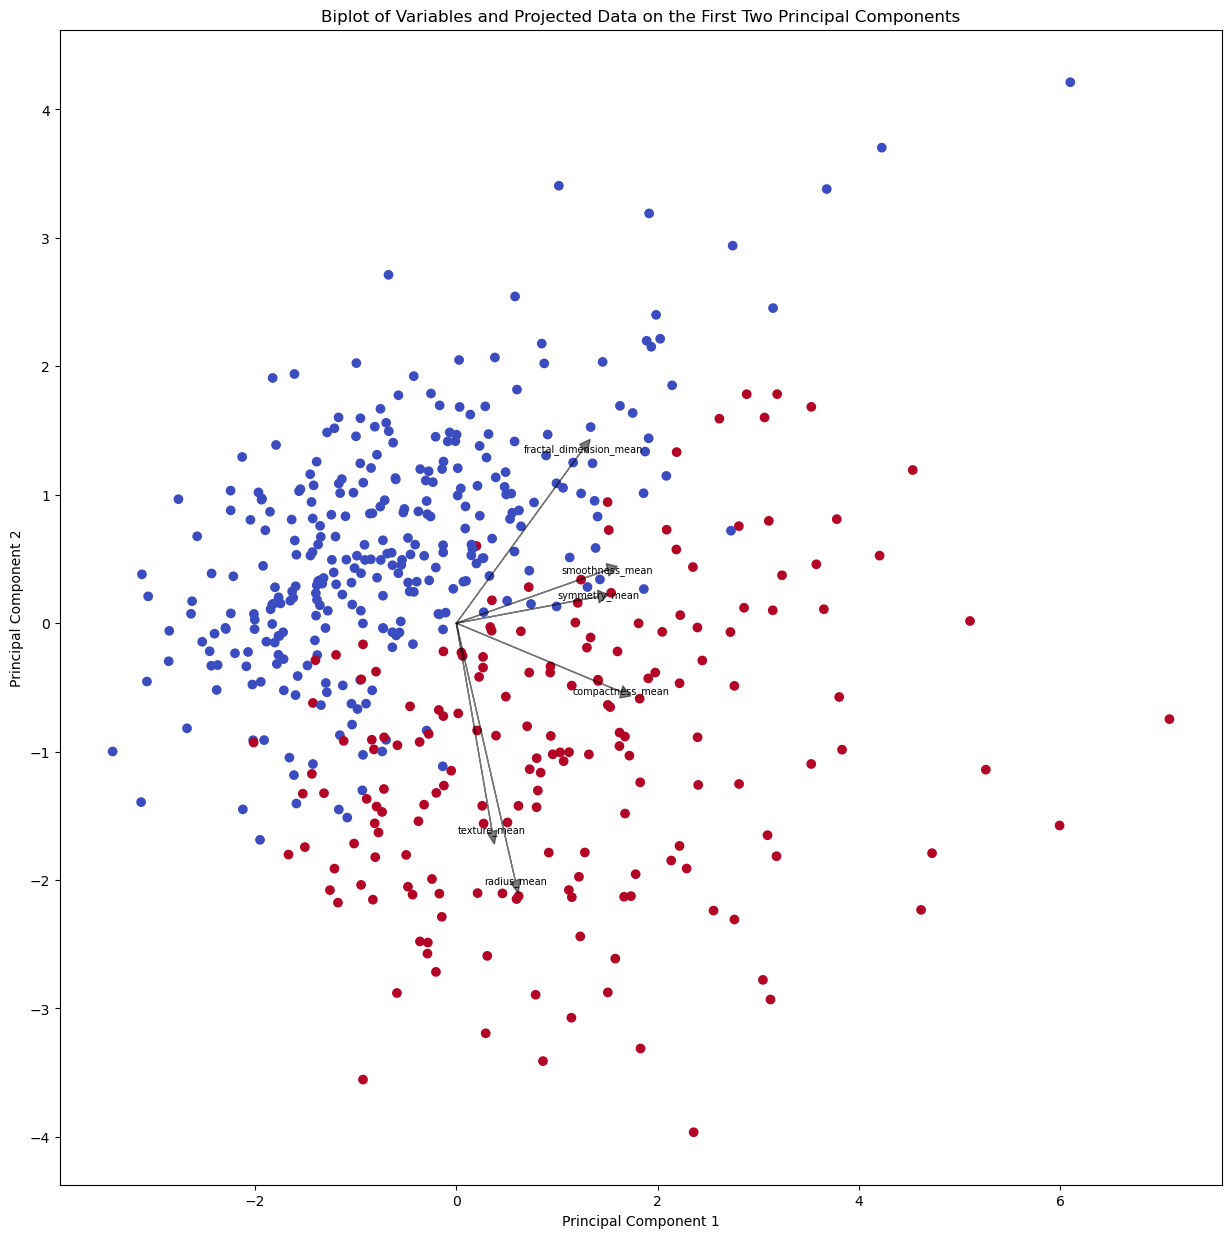

In [41]:
# Step 1: Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

# Step 2: Preprocess the data
# data = pd.read_csv("breast-cancer.csv")
# X = data.iloc[:, 2:]  # Features
# y = data.iloc[:, 1]  # Target variable

# # Encode the target variable if it's categorical (Malignant: M, Benign: B)
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)

# Step 3: Perform PCA
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X)

# Step 4: Create the biplot
fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='coolwarm')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('Biplot of Variables and Projected Data on the First Two Principal Components')

# Plot variable vectors as arrows
feature_vectors = pca.components_.T
scale_factor = 3  # Adjust the scaling factor as needed
for i, feature in enumerate(X.columns):
    ax.arrow(0, 0, scale_factor * feature_vectors[i, 0], scale_factor * feature_vectors[i, 1], color='black', alpha=0.5, head_width=0.1, head_length=0.1)
    ax.text(scale_factor * feature_vectors[i, 0], scale_factor * feature_vectors[i, 1], feature, color='black', ha='center', va='center', fontsize=7)

plt.show()

# Step 5: Interpret the results
# Analyze the biplot to interpret the relationship between variables, the direction and strength of their associations with the principal components, and the separation of data points for the two categories.


More the radius and texture mean and compactness mean, the conclusion is that it's malignant as pointed by logistic regression. `m


To determine which variables are more related to the tumor status based on the plot from Task 4 (biplot), you can analyze the direction and proximity of the feature vectors to the tumor status categories. Here's how you can interpret the biplot and compare the results with Task 2:

1. Direction: Look at the direction of the feature vectors (arrows) in the biplot. Variables that have a closer alignment with the tumor status categories (Malignant and Benign) are more likely to be related to the tumor status. If a feature vector points towards one of the categories, it suggests that the corresponding variable has a strong association with that category.

2. Proximity: Examine the proximity of the feature vectors to the tumor status categories. Variables that are located closer to a particular category indicate a stronger relationship with that category. The closer the feature vector is to a category, the more influential the corresponding variable is in determining the tumor status.

By considering both the direction and proximity of the feature vectors in the biplot, you can identify the variables that are more related to the tumor status.

Compare the results obtained in Task 2 (Logistic Regression and Decision Tree) with the results from Task 4 (biplot):

- Task 2: In Task 2, logistic regression and decision tree models were used to predict the tumor status. The models provide information about the importance or impact of different variables on the prediction. You can analyze the coefficients or feature importances from the models to identify the variables that have a higher chance of impacting the prediction of the tumor status.

- Task 4: In Task 4, the biplot provides visual information about the relationship between variables and the tumor status based on the first two principal components. By analyzing the direction and proximity of the feature vectors in the biplot, you can infer which variables are more related to the tumor status.

Compare the results obtained from both tasks to see if there are any similarities or differences in identifying the variables that are more related to the tumor status. Consider factors such as the strength of association, consistency of findings, and the overall interpretation of the results.

Note: It's important to keep in mind that the results and interpretations may vary depending on the specific dataset and the analysis performed.

 nearere to each other means they are correlated as well

In [42]:
pca_95 = PCA(n_components=0.95)
X_pca = pca_95.fit_transform(X_train_scaled)

In [43]:
pca_95.n_components_

5

In [44]:
X_pca[0]

array([-0.14116331,  1.20037558,  0.59104967,  1.76858603, -0.06821319])

In [45]:
y_train.shape

(483,)

In [46]:
from sklearn.metrics import accuracy_score

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_train, test_size=0.2, random_state=42)
model = LogisticRegression()
model.fit(X_train_pca, y_train_pca)
y_pred_pca = model.predict(X_test_pca)

# Step 6: Evaluate the performance and compare with the original features
accuracy = accuracy_score(y_test_pca, y_pred_pca)
# dimension_new_dataset = X_transformed.shape[1]

In [47]:
accuracy

0.9175257731958762

In [ ]:
# we can print confusion matrix, accuracy , f1 score, precision and recall. among other things and explain them. We ca

In [53]:
pca_95.


6

In [ ]:
# also find the reduced features and which one was removed. And discuss about it. 